# Описание задачи

[Дан набор 3D примитивов](https://drive.google.com/file/d/1xM5diKjMbp_PfNu--JG2A-ZeFk9TLkks/view?usp=sharing). Необходимо решить задачу классификации объектов с помощью нейронной сети, представленных в форме облака точек.

Набор данных разбит на три части: `train`, `test`, `valid`.

Для этого нужно:

1. Используя набор данных из категории `train` обучить модель классификации.
2. Оценить качество её работы на объектах из категории `test`. Для этого воспользоваться [classification_report из scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html?highlight=report#sklearn.metrics.classification_report). Провести финальную оценку на `valid`. Написать краткий отчёт по результатам оценки качества модели: насколько хорошо/плохо работает модель, насколько она обобщается на данные из `valid` набора, что можно сделать для улучшения результатов.


Задачу можно решать в [Google Colab](https://colab.research.google.com/), если нет возможности использовать GPU.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm

import random
import math

import trimesh
import matplotlib.pyplot as plt
import glob
import numpy as np
from collections import Counter
import os

В первый раз сталкиваюсь с подобной задачей. Посмотрев на данные не очень понятно, как это было обучать. Нашел пример [здесь](https://keras.io/examples/vision/pointnet/), что послужило хорошим началом. 

## Считывание данных

In [2]:
mesh = trimesh.load("./dataset-v2/cone/test/Cone.003.obj")
mesh.show()

ValueError: string is not a file: ./dataset-v2/cone/test/Cone.003.obj

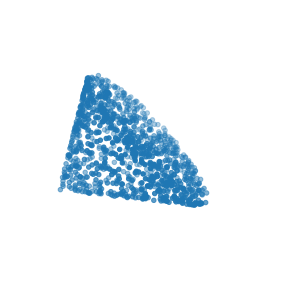

In [3]:
points = mesh.sample(1024)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [4]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    val_points = []
    val_labels = []
    class_map = {}
    
    train_counter = Counter()
    val_counter = Counter()
    test_counter = Counter()
    
    folders = glob.glob(os.path.join('./', "dataset-v2/*"))
    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))
        val_files = glob.glob(os.path.join(folder, "valid/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)
            train_counter[i] += 1

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)
            test_counter[i] += 1
            
        for f in val_files:
            val_points.append(trimesh.load(f).sample(num_points))
            val_labels.append(i)
            val_counter[i] += 1

    return (
        np.array(train_points),
        np.array(val_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(val_labels),
        np.array(test_labels),
        class_map,
    ), (
        train_counter, 
        val_counter, 
        test_counter
    )

In [5]:
NUM_POINTS = 1024
NUM_CLASSES = 6
BATCH_SIZE = 16

(
    train_points, 
    val_points, 
    test_points, 
    train_labels, 
    val_labels, 
    test_labels, 
    CLASS_MAP), (
    train_counter, 
    val_counter, 
    test_counter
) = parse_dataset(NUM_POINTS)

processing class: cone
processing class: cube
processing class: cylinder
processing class: plane
processing class: torus
processing class: uv_sphere


In [6]:
train_counter

Counter({0: 264, 1: 120, 2: 360, 3: 60, 4: 276, 5: 120})

In [7]:
val_counter

Counter({0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50})

In [8]:
test_counter

Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100})

In [9]:
print(len(train_points), len(val_points) , len(test_points))

1200 300 600


In [10]:
class Data(Dataset):
    def __init__(self, points, labels, transform = None):
        self.points = points
        self.labels = labels
        
        self.transform = transform
    
    def __len__(self):
        return len(self.points)
    
    def __getitem__(self, idx):
        point = self.points[idx]
        label = self.labels[idx]
        if self.transform:
            point = self.transform(point)
        return point, label

## Transforms

In [11]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [12]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [13]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [14]:
train_transforms = transforms.Compose([
    Normalize(),
    RandRotation_z(),
    RandomNoise(),
    ToTensor()
])

val_transforms = transforms.Compose([
    Normalize(),
    ToTensor()
])

In [15]:
train_data = Data(train_points, train_labels, train_transforms)
val_data = Data(val_points, val_labels, val_transforms)
test_data = Data(test_points, test_labels, val_transforms)

In [16]:
train_dataloader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    num_workers=0, 
    pin_memory=True,
    shuffle=True, 
    drop_last=True
)

val_dataloader = DataLoader(
    val_data, 
    batch_size=BATCH_SIZE, 
    num_workers=0, 
    pin_memory=True,
    shuffle=False, 
    drop_last=False
)

test_dataloader = DataLoader(
    test_data, 
    batch_size=1, 
    num_workers=0, 
    pin_memory=True,
    shuffle=False, 
    drop_last=False
)

## Модель через свертки

Для начала решил попробовать настакать обычных сверток с батч нормализацией, после чего все подавать в линейный слой для классификации.

In [54]:
class CNNModel(nn.Module):
    def __init__(
        self,
        input_dim, 
        in_channels,
        out_channels,
        output_dim,
        device
    ):
        
        super().__init__()
        
        self.cnn1 = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        
        self.cnn2 = nn.Conv1d(out_channels, out_channels * 4, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(out_channels * 4)
        
        self.cnn3 = nn.Conv1d(out_channels * 4, out_channels * 8, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(out_channels * 8)
        
        self.cnn4 = nn.Conv1d(out_channels * 8, out_channels * 8, kernel_size=1)
        self.bn4 = nn.BatchNorm1d(out_channels * 8)
        
        self.cnn5 = nn.Conv1d(out_channels * 8, out_channels * 4, kernel_size=1)
        self.bn5 = nn.BatchNorm1d(out_channels * 4)
        
        self.cnn6 = nn.Conv1d(out_channels * 4, out_channels * 2, kernel_size=1)
        self.bn6 = nn.BatchNorm1d(out_channels * 2)
        
        self.cnn7 = nn.Conv1d(out_channels * 2, out_channels, kernel_size=1)
        self.bn7 = nn.BatchNorm1d(out_channels)
        
        self.linear = nn.Linear(in_features=out_channels, out_features=output_dim)
        
        self.device = device
        
    def forward(self, x):
        output = self.cnn1(x)
        output = torch.relu(self.bn1(output))
        
        output = self.cnn2(output)
        output = torch.relu(self.bn2(output))
        
        output = self.cnn3(output)
        output = torch.relu(self.bn3(output))
        
        output = self.cnn4(output)
        output = torch.relu(self.bn4(output))
        
        output = self.cnn5(output)
        output = torch.relu(self.bn5(output))
        
        output = self.cnn6(output)
        output = torch.relu(self.bn6(output))
        
        output = self.cnn7(output)
        output = torch.relu(self.bn7(output))

        pool = nn.MaxPool1d(output.size(-1))(output)
        flat = nn.Flatten(1)(pool)
        output = self.linear(flat)
        return output

In [55]:
def evaluate(model, data_loader, loss_fn, device='cpu'):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for points, labels in tqdm(data_loader, total=len(data_loader)):
            preds = model(points.float().to(device).permute(0, 2, 1)).cpu()
            loss = loss_fn(preds, labels.long())
            val_loss.append(loss.item())
    return np.mean(val_loss)

def train_epoch(model, optim, loss_fn, train_dataloader, device='cpu'):
    model.train()
    train_loss = []
    for points, labels in tqdm(train_dataloader, total=len(train_dataloader)):
        optim.zero_grad()

        preds = model(points.float().to(device).permute(0, 2, 1)).cpu()
        loss = loss_fn(preds, labels.long())
        train_loss.append(loss.item())

        loss.backward()
        optim.step()
    return np.mean(train_loss)

def train(model, optim, loss_fn, train_dataloader, val_dataloader, epochs=20, device='cpu'):
    model.train()
    model.to(device)
    for epoch in range(epochs):
        train_loss = train_epoch(model, optim, loss_fn, train_dataloader, device=device)
        val_loss = evaluate(model, val_dataloader, loss_fn, device=device)
        tqdm.write(f"Epoch: {epoch+1}  train_loss: {train_loss:.3f}  val_loss: {val_loss:.3f}")

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(
    input_dim=NUM_POINTS, 
    in_channels=3, 
    out_channels=8,
    output_dim=NUM_CLASSES,
    device=device
)

optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
train(model, optim, loss_fn, train_dataloader, val_dataloader, epochs=30, device=device)

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 1  train_loss: 2.019  val_loss: 1.696


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 2  train_loss: 1.461  val_loss: 1.485


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 3  train_loss: 1.282  val_loss: 1.363


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 4  train_loss: 1.181  val_loss: 1.274


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 5  train_loss: 1.093  val_loss: 1.202


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 6  train_loss: 1.059  val_loss: 1.132


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 7  train_loss: 1.000  val_loss: 1.099


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 8  train_loss: 0.978  val_loss: 1.052


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 9  train_loss: 0.946  val_loss: 1.034


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 10  train_loss: 0.903  val_loss: 1.022


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 11  train_loss: 0.870  val_loss: 0.961


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 12  train_loss: 0.841  val_loss: 0.941


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 13  train_loss: 0.859  val_loss: 0.912


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 14  train_loss: 0.810  val_loss: 0.921


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 15  train_loss: 0.819  val_loss: 0.876


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 16  train_loss: 0.813  val_loss: 0.845


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 17  train_loss: 0.780  val_loss: 0.803


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 18  train_loss: 0.775  val_loss: 0.747


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 19  train_loss: 0.744  val_loss: 0.733


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 20  train_loss: 0.721  val_loss: 0.667


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 21  train_loss: 0.725  val_loss: 0.599


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 22  train_loss: 0.687  val_loss: 0.596


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 23  train_loss: 0.685  val_loss: 0.536


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 24  train_loss: 0.658  val_loss: 0.542


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 25  train_loss: 0.622  val_loss: 0.579


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 26  train_loss: 0.625  val_loss: 0.510


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 27  train_loss: 0.617  val_loss: 0.506


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 28  train_loss: 0.587  val_loss: 0.504


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 29  train_loss: 0.585  val_loss: 0.480


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 30  train_loss: 0.582  val_loss: 0.485


In [57]:
from sklearn.metrics import classification_report

In [60]:
def test_eval(model, dataloader, device='cpu'):
    model.eval()
    model.to(device)
    preds = []
    targets = []
    for points, labels in tqdm(dataloader, total=len(dataloader)):
        output = model(points.float().to(device).permute(0, 2, 1)).cpu()
        output = torch.argmax(output, dim=1)
        preds.append(output.item())
        targets.append(labels.long().item())
    print(classification_report(targets, preds))

In [61]:
test_eval(model, test_dataloader, device)

  0%|          | 0/600 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.87      0.72      0.79       100
           1       0.82      0.53      0.64       100
           2       0.59      0.91      0.72       100
           3       1.00      0.99      0.99       100
           4       0.81      0.76      0.78       100
           5       0.94      1.00      0.97       100

    accuracy                           0.82       600
   macro avg       0.84      0.82      0.82       600
weighted avg       0.84      0.82      0.82       600



данная модель относительно неплохо себя показала, однако можно заметить, что recall на классе 1 (Cube) всего 0.53, что означает большое количество FN для данного класса.

## PontNet Model

После решил поискать различные модельки, и наткнулся на [статью](https://towardsdatascience.com/deep-learning-on-point-clouds-implementing-pointnet-in-google-colab-1fd65cd3a263) с [кодом](https://github.com/nikitakaraevv/pointnet/blob/master/nbs/PointNetClass.ipynb) на гите.

In [17]:
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs, 1, 1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1, self.k, self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3, 64, 1)

        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input, 1, 2), matrix3x3).transpose(1, 2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb, 1, 2), matrix64x64).transpose(1, 2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output

class PointNet(nn.Module):
    def __init__(self, classes=10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output)

In [19]:
def pointnetloss(outputs, labels):
    criterion = torch.nn.NLLLoss()
    return criterion(outputs, labels)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pointnet = PointNet(classes=NUM_CLASSES)
pointnet.to(device);

In [21]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [22]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, (points, labels) in tqdm(enumerate(train_loader, 0)):
            inputs, labels = points.to(device).float(), labels.long().to(device)
            optimizer.zero_grad()
            outputs = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    tqdm.write(f"[Epoch: {epoch + 1}, Batch: {i + 1} / {len(train_loader)}], loss: {(running_loss / 10):.3f}")
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                losses = 0
                for points, labels in tqdm(val_loader):
                    inputs, labels = points.to(device).float(), labels.long().to(device)
                    outputs = pointnet(inputs.transpose(1,2))
                    loss = pointnetloss(outputs, labels)
                    losses += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            tqdm.write(f"Valid loss: {(losses / len(val_loader)):.3f}, Valid accuracy: {val_acc:.3f}")

        # save the model
        if save:
            torch.save(pointnet.state_dict(), f"runs/save_{epoch}.pth")

In [23]:
train(pointnet, train_dataloader, val_dataloader,  epochs=30, save=False)

0it [00:00, ?it/s]

[Epoch: 1, Batch: 10 / 75], loss: 1.569
[Epoch: 1, Batch: 20 / 75], loss: 1.214
[Epoch: 1, Batch: 30 / 75], loss: 1.060
[Epoch: 1, Batch: 40 / 75], loss: 0.941
[Epoch: 1, Batch: 50 / 75], loss: 0.989
[Epoch: 1, Batch: 60 / 75], loss: 0.869
[Epoch: 1, Batch: 70 / 75], loss: 0.845


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.941, Valid accuracy: 67.667


0it [00:00, ?it/s]

[Epoch: 2, Batch: 10 / 75], loss: 0.684
[Epoch: 2, Batch: 20 / 75], loss: 0.789
[Epoch: 2, Batch: 30 / 75], loss: 0.634
[Epoch: 2, Batch: 40 / 75], loss: 0.606
[Epoch: 2, Batch: 50 / 75], loss: 0.492
[Epoch: 2, Batch: 60 / 75], loss: 0.444
[Epoch: 2, Batch: 70 / 75], loss: 0.500


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.761, Valid accuracy: 68.333


0it [00:00, ?it/s]

[Epoch: 3, Batch: 10 / 75], loss: 0.787
[Epoch: 3, Batch: 20 / 75], loss: 0.422
[Epoch: 3, Batch: 30 / 75], loss: 0.421
[Epoch: 3, Batch: 40 / 75], loss: 0.411
[Epoch: 3, Batch: 50 / 75], loss: 0.540
[Epoch: 3, Batch: 60 / 75], loss: 0.435
[Epoch: 3, Batch: 70 / 75], loss: 0.407


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 1.861, Valid accuracy: 46.667


0it [00:00, ?it/s]

[Epoch: 4, Batch: 10 / 75], loss: 0.510
[Epoch: 4, Batch: 20 / 75], loss: 0.672
[Epoch: 4, Batch: 30 / 75], loss: 0.673
[Epoch: 4, Batch: 40 / 75], loss: 0.429
[Epoch: 4, Batch: 50 / 75], loss: 0.325
[Epoch: 4, Batch: 60 / 75], loss: 0.570
[Epoch: 4, Batch: 70 / 75], loss: 0.353


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.286, Valid accuracy: 91.000


0it [00:00, ?it/s]

[Epoch: 5, Batch: 10 / 75], loss: 0.507
[Epoch: 5, Batch: 20 / 75], loss: 0.338
[Epoch: 5, Batch: 30 / 75], loss: 0.248
[Epoch: 5, Batch: 40 / 75], loss: 0.481
[Epoch: 5, Batch: 50 / 75], loss: 0.303
[Epoch: 5, Batch: 60 / 75], loss: 0.224
[Epoch: 5, Batch: 70 / 75], loss: 0.649


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.380, Valid accuracy: 83.000


0it [00:00, ?it/s]

[Epoch: 6, Batch: 10 / 75], loss: 0.449
[Epoch: 6, Batch: 20 / 75], loss: 0.291
[Epoch: 6, Batch: 30 / 75], loss: 0.165
[Epoch: 6, Batch: 40 / 75], loss: 0.454
[Epoch: 6, Batch: 50 / 75], loss: 0.217
[Epoch: 6, Batch: 60 / 75], loss: 0.476
[Epoch: 6, Batch: 70 / 75], loss: 0.453


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.283, Valid accuracy: 88.333


0it [00:00, ?it/s]

[Epoch: 7, Batch: 10 / 75], loss: 0.278
[Epoch: 7, Batch: 20 / 75], loss: 0.354
[Epoch: 7, Batch: 30 / 75], loss: 0.237
[Epoch: 7, Batch: 40 / 75], loss: 0.306
[Epoch: 7, Batch: 50 / 75], loss: 0.287
[Epoch: 7, Batch: 60 / 75], loss: 0.252
[Epoch: 7, Batch: 70 / 75], loss: 0.444


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.241, Valid accuracy: 92.000


0it [00:00, ?it/s]

[Epoch: 8, Batch: 10 / 75], loss: 0.344
[Epoch: 8, Batch: 20 / 75], loss: 0.344
[Epoch: 8, Batch: 30 / 75], loss: 0.331
[Epoch: 8, Batch: 40 / 75], loss: 0.305
[Epoch: 8, Batch: 50 / 75], loss: 0.395
[Epoch: 8, Batch: 60 / 75], loss: 0.470
[Epoch: 8, Batch: 70 / 75], loss: 0.155


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.269, Valid accuracy: 96.000


0it [00:00, ?it/s]

[Epoch: 9, Batch: 10 / 75], loss: 0.161
[Epoch: 9, Batch: 20 / 75], loss: 0.142
[Epoch: 9, Batch: 30 / 75], loss: 0.251
[Epoch: 9, Batch: 40 / 75], loss: 0.209
[Epoch: 9, Batch: 50 / 75], loss: 0.139
[Epoch: 9, Batch: 60 / 75], loss: 0.173
[Epoch: 9, Batch: 70 / 75], loss: 0.438


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.576, Valid accuracy: 82.667


0it [00:00, ?it/s]

[Epoch: 10, Batch: 10 / 75], loss: 0.238
[Epoch: 10, Batch: 20 / 75], loss: 0.513
[Epoch: 10, Batch: 30 / 75], loss: 0.189
[Epoch: 10, Batch: 40 / 75], loss: 0.513
[Epoch: 10, Batch: 50 / 75], loss: 0.248
[Epoch: 10, Batch: 60 / 75], loss: 0.456
[Epoch: 10, Batch: 70 / 75], loss: 0.346


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.286, Valid accuracy: 87.333


0it [00:00, ?it/s]

[Epoch: 11, Batch: 10 / 75], loss: 0.260
[Epoch: 11, Batch: 20 / 75], loss: 0.327
[Epoch: 11, Batch: 30 / 75], loss: 0.309
[Epoch: 11, Batch: 40 / 75], loss: 0.381
[Epoch: 11, Batch: 50 / 75], loss: 0.250
[Epoch: 11, Batch: 60 / 75], loss: 0.177
[Epoch: 11, Batch: 70 / 75], loss: 0.297


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.379, Valid accuracy: 85.667


0it [00:00, ?it/s]

[Epoch: 12, Batch: 10 / 75], loss: 0.184
[Epoch: 12, Batch: 20 / 75], loss: 0.203
[Epoch: 12, Batch: 30 / 75], loss: 0.163
[Epoch: 12, Batch: 40 / 75], loss: 0.141
[Epoch: 12, Batch: 50 / 75], loss: 0.202
[Epoch: 12, Batch: 60 / 75], loss: 0.126
[Epoch: 12, Batch: 70 / 75], loss: 0.095


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.231, Valid accuracy: 96.333


0it [00:00, ?it/s]

[Epoch: 13, Batch: 10 / 75], loss: 0.193
[Epoch: 13, Batch: 20 / 75], loss: 0.323
[Epoch: 13, Batch: 30 / 75], loss: 0.300
[Epoch: 13, Batch: 40 / 75], loss: 0.298
[Epoch: 13, Batch: 50 / 75], loss: 0.215
[Epoch: 13, Batch: 60 / 75], loss: 0.161
[Epoch: 13, Batch: 70 / 75], loss: 0.173


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.160, Valid accuracy: 94.667


0it [00:00, ?it/s]

[Epoch: 14, Batch: 10 / 75], loss: 0.236
[Epoch: 14, Batch: 20 / 75], loss: 0.248
[Epoch: 14, Batch: 30 / 75], loss: 0.188
[Epoch: 14, Batch: 40 / 75], loss: 0.151
[Epoch: 14, Batch: 50 / 75], loss: 0.103
[Epoch: 14, Batch: 60 / 75], loss: 0.273
[Epoch: 14, Batch: 70 / 75], loss: 0.509


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.252, Valid accuracy: 86.333


0it [00:00, ?it/s]

[Epoch: 15, Batch: 10 / 75], loss: 0.141
[Epoch: 15, Batch: 20 / 75], loss: 0.083
[Epoch: 15, Batch: 30 / 75], loss: 0.147
[Epoch: 15, Batch: 40 / 75], loss: 0.074
[Epoch: 15, Batch: 50 / 75], loss: 0.283
[Epoch: 15, Batch: 60 / 75], loss: 0.191
[Epoch: 15, Batch: 70 / 75], loss: 0.344


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.206, Valid accuracy: 96.000


0it [00:00, ?it/s]

[Epoch: 16, Batch: 10 / 75], loss: 0.281
[Epoch: 16, Batch: 20 / 75], loss: 0.273
[Epoch: 16, Batch: 30 / 75], loss: 0.178
[Epoch: 16, Batch: 40 / 75], loss: 0.124
[Epoch: 16, Batch: 50 / 75], loss: 0.142
[Epoch: 16, Batch: 60 / 75], loss: 0.209
[Epoch: 16, Batch: 70 / 75], loss: 0.068


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.048, Valid accuracy: 100.000


0it [00:00, ?it/s]

[Epoch: 17, Batch: 10 / 75], loss: 0.150
[Epoch: 17, Batch: 20 / 75], loss: 0.107
[Epoch: 17, Batch: 30 / 75], loss: 0.126
[Epoch: 17, Batch: 40 / 75], loss: 0.258
[Epoch: 17, Batch: 50 / 75], loss: 0.176
[Epoch: 17, Batch: 60 / 75], loss: 0.108
[Epoch: 17, Batch: 70 / 75], loss: 0.095


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.105, Valid accuracy: 97.667


0it [00:00, ?it/s]

[Epoch: 18, Batch: 10 / 75], loss: 0.221
[Epoch: 18, Batch: 20 / 75], loss: 0.088
[Epoch: 18, Batch: 30 / 75], loss: 0.086
[Epoch: 18, Batch: 40 / 75], loss: 0.064
[Epoch: 18, Batch: 50 / 75], loss: 0.109
[Epoch: 18, Batch: 60 / 75], loss: 0.077
[Epoch: 18, Batch: 70 / 75], loss: 0.087


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.019, Valid accuracy: 100.000


0it [00:00, ?it/s]

[Epoch: 19, Batch: 10 / 75], loss: 0.059
[Epoch: 19, Batch: 20 / 75], loss: 0.137
[Epoch: 19, Batch: 30 / 75], loss: 0.178
[Epoch: 19, Batch: 40 / 75], loss: 0.134
[Epoch: 19, Batch: 50 / 75], loss: 0.193
[Epoch: 19, Batch: 60 / 75], loss: 0.191
[Epoch: 19, Batch: 70 / 75], loss: 0.276


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.668, Valid accuracy: 80.333


0it [00:00, ?it/s]

[Epoch: 20, Batch: 10 / 75], loss: 0.207
[Epoch: 20, Batch: 20 / 75], loss: 0.241
[Epoch: 20, Batch: 30 / 75], loss: 0.173
[Epoch: 20, Batch: 40 / 75], loss: 0.173
[Epoch: 20, Batch: 50 / 75], loss: 0.130
[Epoch: 20, Batch: 60 / 75], loss: 0.091
[Epoch: 20, Batch: 70 / 75], loss: 0.106


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.047, Valid accuracy: 98.667


0it [00:00, ?it/s]

[Epoch: 21, Batch: 10 / 75], loss: 0.125
[Epoch: 21, Batch: 20 / 75], loss: 0.084
[Epoch: 21, Batch: 30 / 75], loss: 0.034
[Epoch: 21, Batch: 40 / 75], loss: 0.236
[Epoch: 21, Batch: 50 / 75], loss: 0.107
[Epoch: 21, Batch: 60 / 75], loss: 0.100
[Epoch: 21, Batch: 70 / 75], loss: 0.212


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.073, Valid accuracy: 98.000


0it [00:00, ?it/s]

[Epoch: 22, Batch: 10 / 75], loss: 0.227
[Epoch: 22, Batch: 20 / 75], loss: 0.208
[Epoch: 22, Batch: 30 / 75], loss: 0.221
[Epoch: 22, Batch: 40 / 75], loss: 0.261
[Epoch: 22, Batch: 50 / 75], loss: 0.172
[Epoch: 22, Batch: 60 / 75], loss: 0.128
[Epoch: 22, Batch: 70 / 75], loss: 0.086


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.064, Valid accuracy: 99.000


0it [00:00, ?it/s]

[Epoch: 23, Batch: 10 / 75], loss: 0.170
[Epoch: 23, Batch: 20 / 75], loss: 0.233
[Epoch: 23, Batch: 30 / 75], loss: 0.214
[Epoch: 23, Batch: 40 / 75], loss: 0.279
[Epoch: 23, Batch: 50 / 75], loss: 0.456
[Epoch: 23, Batch: 60 / 75], loss: 0.130
[Epoch: 23, Batch: 70 / 75], loss: 0.177


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.143, Valid accuracy: 92.000


0it [00:00, ?it/s]

[Epoch: 24, Batch: 10 / 75], loss: 0.144
[Epoch: 24, Batch: 20 / 75], loss: 0.255
[Epoch: 24, Batch: 30 / 75], loss: 0.103
[Epoch: 24, Batch: 40 / 75], loss: 0.080
[Epoch: 24, Batch: 50 / 75], loss: 0.057
[Epoch: 24, Batch: 60 / 75], loss: 0.296
[Epoch: 24, Batch: 70 / 75], loss: 0.063


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.052, Valid accuracy: 100.000


0it [00:00, ?it/s]

[Epoch: 25, Batch: 10 / 75], loss: 0.123
[Epoch: 25, Batch: 20 / 75], loss: 0.041
[Epoch: 25, Batch: 30 / 75], loss: 0.124
[Epoch: 25, Batch: 40 / 75], loss: 0.104
[Epoch: 25, Batch: 50 / 75], loss: 0.373
[Epoch: 25, Batch: 60 / 75], loss: 0.247
[Epoch: 25, Batch: 70 / 75], loss: 0.214


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.043, Valid accuracy: 99.667


0it [00:00, ?it/s]

[Epoch: 26, Batch: 10 / 75], loss: 0.166
[Epoch: 26, Batch: 20 / 75], loss: 0.175
[Epoch: 26, Batch: 30 / 75], loss: 0.077
[Epoch: 26, Batch: 40 / 75], loss: 0.071
[Epoch: 26, Batch: 50 / 75], loss: 0.093
[Epoch: 26, Batch: 60 / 75], loss: 0.220
[Epoch: 26, Batch: 70 / 75], loss: 0.296


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.274, Valid accuracy: 86.000


0it [00:00, ?it/s]

[Epoch: 27, Batch: 10 / 75], loss: 0.129
[Epoch: 27, Batch: 20 / 75], loss: 0.108
[Epoch: 27, Batch: 30 / 75], loss: 0.109
[Epoch: 27, Batch: 40 / 75], loss: 0.188
[Epoch: 27, Batch: 50 / 75], loss: 0.152
[Epoch: 27, Batch: 60 / 75], loss: 0.194
[Epoch: 27, Batch: 70 / 75], loss: 0.051


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.076, Valid accuracy: 99.667


0it [00:00, ?it/s]

[Epoch: 28, Batch: 10 / 75], loss: 0.114
[Epoch: 28, Batch: 20 / 75], loss: 0.050
[Epoch: 28, Batch: 30 / 75], loss: 0.048
[Epoch: 28, Batch: 40 / 75], loss: 0.049
[Epoch: 28, Batch: 50 / 75], loss: 0.098
[Epoch: 28, Batch: 60 / 75], loss: 0.101
[Epoch: 28, Batch: 70 / 75], loss: 0.061


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.012, Valid accuracy: 100.000


0it [00:00, ?it/s]

[Epoch: 29, Batch: 10 / 75], loss: 0.108
[Epoch: 29, Batch: 20 / 75], loss: 0.250
[Epoch: 29, Batch: 30 / 75], loss: 0.105
[Epoch: 29, Batch: 40 / 75], loss: 0.058
[Epoch: 29, Batch: 50 / 75], loss: 0.094
[Epoch: 29, Batch: 60 / 75], loss: 0.143
[Epoch: 29, Batch: 70 / 75], loss: 0.067


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.067, Valid accuracy: 98.667


0it [00:00, ?it/s]

[Epoch: 30, Batch: 10 / 75], loss: 0.064
[Epoch: 30, Batch: 20 / 75], loss: 0.041
[Epoch: 30, Batch: 30 / 75], loss: 0.063
[Epoch: 30, Batch: 40 / 75], loss: 0.143
[Epoch: 30, Batch: 50 / 75], loss: 0.032
[Epoch: 30, Batch: 60 / 75], loss: 0.053
[Epoch: 30, Batch: 70 / 75], loss: 0.043


  0%|          | 0/19 [00:00<?, ?it/s]

Valid loss: 0.106, Valid accuracy: 99.000


In [24]:
torch.save(pointnet.state_dict(), f"runs/pointnet_30epochs.pth")

In [25]:
from sklearn.metrics import classification_report

In [26]:
labels = []
preds = []
with torch.no_grad():
    for points, label in tqdm(test_dataloader):
        inputs, label = points.to(device).float(), label.long().to(device)
        outputs = pointnet(inputs.transpose(1,2))
        _, predicted = torch.max(outputs.data, 1)
        labels.append(label.item())
        preds.append(predicted.item())

  0%|          | 0/600 [00:00<?, ?it/s]

In [27]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       0.96      1.00      0.98       100
           2       0.93      0.96      0.95       100
           3       1.00      0.96      0.98       100
           4       1.00      1.00      1.00       100
           5       1.00      0.93      0.96       100

    accuracy                           0.97       600
   macro avg       0.98      0.97      0.97       600
weighted avg       0.98      0.97      0.97       600



Данная модель показывает результат намного лучше и увереность в каждом классе довольно большая.